In [29]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [30]:
# Download the actual data from https://files.grouplens.org/datasets/serendipity-sac2018/serendipity-sac2018.zip"
# Use the ratings.csv file
data_file_url = (
    "https://files.grouplens.org/datasets/serendipity-sac2018/serendipity-sac2018.zip"
)
zipped_file = keras.utils.get_file(
    "serendipity-sac2018.zip", data_file_url, extract=False
)
keras_datasets_path = Path(zipped_file).parents[0]
dir = keras_datasets_path / "serendipity-sac2018"

# Only extract the data the first time the script is run.
if not dir.exists():
    with ZipFile(zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

training_file = dir / "training.csv"
df = pd.read_csv(training_file, nrows=1000)

In [32]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["userId"] = df["userId"].map(user2user_encoded)
df["movieId"] = df["movieId"].map(movie2movie_encoded)

In [33]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 69, Number of Movies: 814, Min rating: 0.5, Max rating: 5.0


In [34]:
df = df.sample(frac=1, random_state=42)
x = df[["userId", "movieId"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [35]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=50,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
18/18 [==============================] - 1s 13ms/step - loss: 0.7058 - val_loss: 0.6976
Epoch 2/5
18/18 [==============================] - 0s 3ms/step - loss: 0.7697 - val_loss: 0.6937
Epoch 3/5
18/18 [==============================] - 0s 4ms/step - loss: 0.7099 - val_loss: 0.6901
Epoch 4/5
18/18 [==============================] - 0s 4ms/step - loss: 0.6966 - val_loss: 0.6866
Epoch 5/5
18/18 [==============================] - 0s 4ms/step - loss: 0.7005 - val_loss: 0.6837


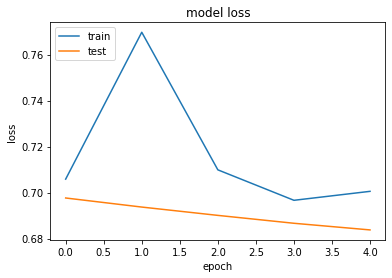

In [37]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [38]:
movie_df = pd.read_csv(dir / "movies.csv", nrows=1000)

In [52]:
# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
user_id

64

In [53]:
movies_watched_by_user = df[df.userId == user_id]
movies_watched_by_user

,userId,movieId,rating,timestamp
973,64,801,3.5,1515193731000
959,64,795,3.0,1515193915000
978,64,510,3.5,1515193646000
977,64,803,4.0,1515193662000
975,64,802,4.5,1515193708000
963,64,799,2.0,1515193876000
960,64,796,2.5,1515193898000
979,64,804,3.0,1515193628000
971,64,734,4.5,1515193777000
967,64,173,0.5,1515193826000


In [54]:
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
movies_not_watched

[[1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [124],
 [125],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138],
 [140],
 [141],
 [143],
 [144],
 [1

In [55]:
user_encoder = user2user_encoded.get(user_id)
user_encoder

64

In [56]:
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
user_movie_array

array([[ 64,   1],
       [ 64,   2],
       [ 64,   3],
       ...,
       [ 64, 810],
       [ 64, 812],
       [ 64, 813]])

In [57]:
ratings = model.predict(user_movie_array).flatten()
ratings

array([0.634435  , 0.62603986, 0.6337962 , 0.6385002 , 0.6342017 ,
       0.6347579 , 0.62579596, 0.6451005 , 0.6429904 , 0.64455426,
       0.63979197, 0.6452208 , 0.6428678 , 0.62937987, 0.6351254 ,
       0.6304492 , 0.64307857, 0.6445639 , 0.6281874 , 0.6360699 ,
       0.6490924 , 0.63094574, 0.6246558 , 0.6343728 , 0.62948495,
       0.644797  , 0.6259515 , 0.6529789 , 0.6349887 , 0.62854123,
       0.63954043, 0.63102365, 0.57875156, 0.5781773 , 0.5779887 ,
       0.57742804, 0.5814185 , 0.56494355, 0.5694319 , 0.5818238 ,
       0.58431685, 0.57327235, 0.57794267, 0.5779705 , 0.56872356,
       0.5566633 , 0.5750941 , 0.5661894 , 0.5683308 , 0.5583107 ,
       0.56360745, 0.5680731 , 0.5680528 , 0.5782113 , 0.56793904,
       0.57705736, 0.5752624 , 0.5654771 , 0.5700925 , 0.5703652 ,
       0.56197053, 0.5792889 , 0.5721379 , 0.5728454 , 0.48891884,
       0.49995476, 0.4879926 , 0.49142194, 0.48243487, 0.47243083,
       0.47800115, 0.48775673, 0.4828018 , 0.47117922, 0.48824

In [58]:
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)

top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 64
Movies with high ratings from user
--------------------------------
Getting Away With Murder (1996) : Comedy
Lone Star (1996) : Drama,Mystery,Western
Harriet the Spy (1996) : Children,Comedy
Phenomenon (1996) : Drama,Romance
Walking and Talking (1996) : Comedy,Drama,Romance


In [59]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

--------------------------------
Top 10 movie recommendations
--------------------------------
Tom and Huck (1995) : Adventure,Children
Sudden Death (1995) : Action
GoldenEye (1995) : Action,Adventure,Thriller
Dracula: Dead and Loving It (1995) : Comedy,Horror
Balto (1995) : Adventure,Animation,Children
Sense and Sensibility (1995) : Drama,Romance
Four Rooms (1995) : Comedy
Get Shorty (1995) : Comedy,Crime,Thriller
Othello (1995) : Drama
Persuasion (1995) : Drama,Romance
